# Visualization of the Central Limit Theorem

 The general statement of the central limit theory (CLT) is that the sum of $n$ random variables drawn from *any* pdf (or multiple pdfs) of finite variance $\sigma^2$ tends as $n\rightarrow\infty$ to be Gaussian distributed about the expectation value of the sum, with variance $n\sigma^2$.  (So we would scale the sum by $1/\sqrt{n}$ to keep the variance fixed.) In this notebook we look visually at several consequences of the CLT. 

In [1]:
# set up for plots in this notebook using matplotlib 
%matplotlib inline   

import scipy.stats as stats  # We'll use stats as our source of pdfs
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # nicer plots!


## Limit of Poisson distribution is Gaussian

One consequence of the CLT is that distributions such as the Binomial and Poisson distributions all tend to look like Gaussian distributions in the limit of a large number of drawings.
Here we visualize that the Poisson distribution in the limit $D \rightarrow \infty$ approaches a Gaussian distribution:

$$
 p(N \mid D) = \frac{D^N e^{-D}}{N!} 
 \stackrel{D\rightarrow\infty}{\longrightarrow} \frac{1}{\sqrt{2\pi D}}e^{-(N-D)^2/(2D)}
$$

with $N$ an integer. *You will be asked to prove this limit in a later notebook.*

**Note: this limiting functional form is not obviously connected to the general statement of the CLT up above. What is the connection? We'll come back below to adress this question.** 

This visualization is adapted from the `amplitude_in_presence_of_background_RECAP.ipynb` notebook.

In [2]:
from math import factorial

In [3]:
def poisson(N, D):
    """
    Returns a Poisson distribution value with mean D for integer N.
    We require N to be an integer greater than equal to zero.
    UPDATE: using poisson.pmf from scipy.stats instead.
    """
    assert (isinstance(N, int) and N >= 0), \
            "N must be a non-negative integer!"

    return D**N * np.exp(-D) / factorial(N) 

def poisson_plot(ax, D, max_N):
    """
    Make a bar plot on the axis ax of the Poisson distribution for mu = D
     and out to a maximum integer max_N.
    Replaced our own poisson function with poisson.pmf from scipy.stats so
     that we can go to larger N. 
    """
    N_pts = np.arange(0, max_N, 1, dtype=int)
    #poisson_pts = [poisson(int(N), D) for N in N_pts]
    poisson_pts = [stats.poisson.pmf(N, D) for N in N_pts]
    ax.bar(N_pts, poisson_pts, width=0.8, bottom=None, align='center')
    ax.set_xlabel(r'Number of counts $N$', fontsize=18)
    ax.set_ylabel(fr'$\mathrm{{p}}(N \mid D={D:.1f})$', fontsize=18)
    ax.set_title(rf'$D = {D:.1f}$', fontsize=20)
    ax.tick_params(labelsize=16)
    return N_pts


In [4]:
poisson(0,1)

0.36787944117144233

Make successive histogram plots of the Poisson distribution, increasing the value of $D$ from 0.5 to 50, and superposing the normal distribution it is supposed to approach.

Note that the arguments of stats.norm.pdf are the # of points, the mean, and the standard deviation (not the variance) of the distribution.

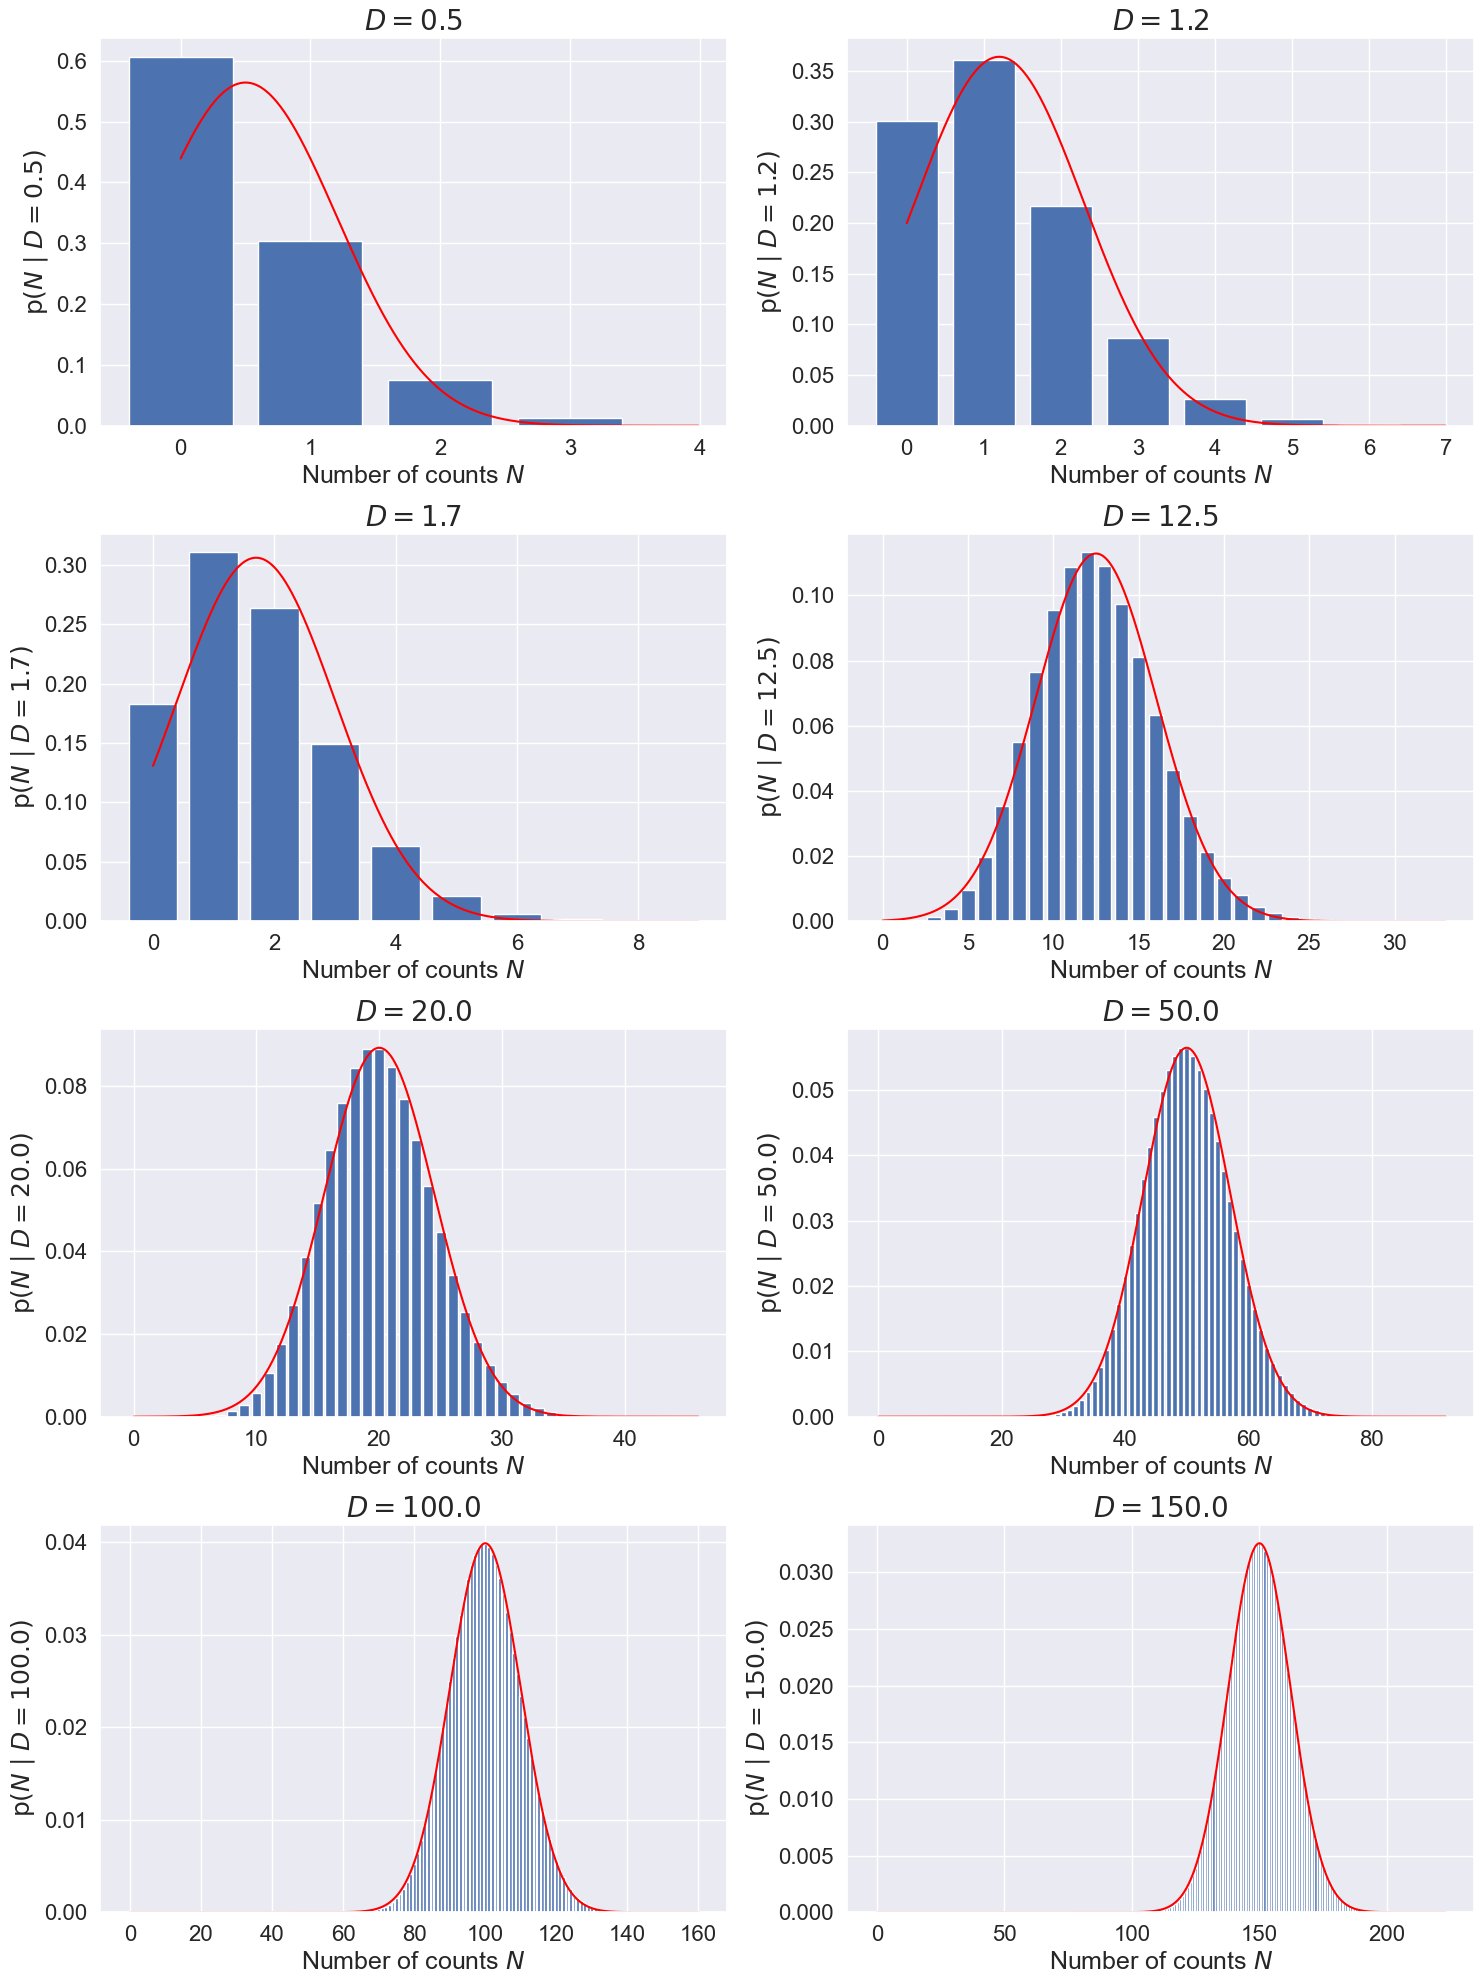

In [5]:
D_list = np.array([0.5, 1.2, 1.7, 12.5, 20., 50., 100., 150.])
num_rows = int(D_list.size / 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

for D, ax in zip(D_list, axes.flatten()):
    max_N = int(D + 6.*np.sqrt(D))  # mean + multiple of standard deviation
    N_pts = np.arange(0, max_N, 0.01)
    y_pts = stats.norm.pdf(N_pts, D, np.sqrt(D))
    poisson_plot(ax, D, max_N)
    ax.plot(N_pts, y_pts, color='red')

fig.tight_layout()

### NEW: Show that Poisson is a sum of smaller Poissons

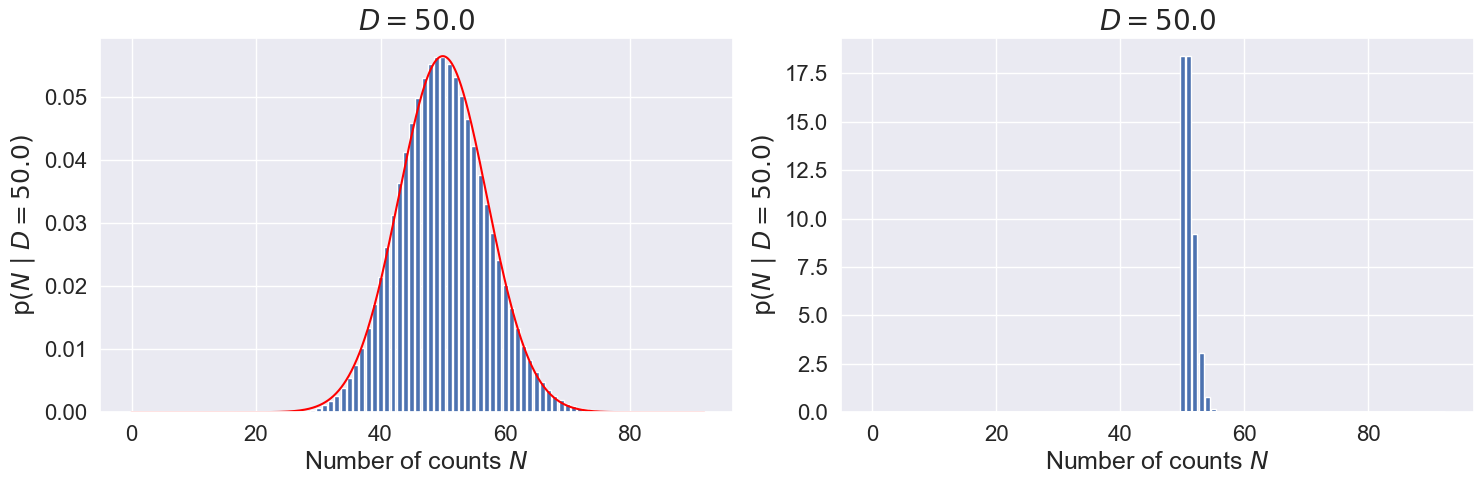

In [16]:
D = 50
num_rows = 1

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

max_N = int(D + 6.*np.sqrt(D))  # mean + multiple of standard deviation
N_pts = np.arange(0, max_N, 0.01)
y_pts = stats.norm.pdf(N_pts, D, np.sqrt(D))
poisson_plot(axes[0], D, max_N)
axes[0].plot(N_pts, y_pts, color='red')

N_pts_2 = np.arange(0, max_N, 0.01)
poisson_pts = [np.sum([stats.poisson.rvs(1) for index in range(D)]) for N in N_pts_2]
axes[1].bar(N_pts, poisson_pts, width=0.8, bottom=None, align='center')
axes[1].set_xlabel(r'Number of counts $N$', fontsize=18)
axes[1].set_ylabel(fr'$\mathrm{{p}}(N \mid D={D:.1f})$', fontsize=18)
axes[1].set_title(rf'$D = {D:.1f}$', fontsize=20)
axes[1].tick_params(labelsize=16)


fig.tight_layout()

In [17]:
N = 50
D_test = 50
poisson_pts_test = np.sum([stats.poisson.rvs(1) for index in range(D_test)])
poisson_pts_test

49

## Behavior of the mean of a fixed-size sample 

Here we take the mean of a fixed-size sample drawn from any pdf, and then repeat a number of times and look at the distribution of the means.  According to the CLT, this distribution should approach a Gaussian pdf.  For our test pdf we'll use a uniform distribution, although this is easy to switch to another distribution.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
 
# Sample the distribution we will use    
#mu, sigma = 0.5, 1.
#pop_normal = np.random.normal(mu, sigma, total_draws)

total_draws = 100000
uni_min, uni_max = 0., 1.
ran_uniform_array = np.random.uniform(uni_min, uni_max, total_draws)

bins = 15

# Find the mean and standard deviation of our distribution, to use for 
#  plotting a comparison Gaussian distribution.
mu = ran_uniform_array.mean()
sigma = ran_uniform_array.std()

print(f' mean of uniform array = {mu:.3f}')
print(f' standard deviation of uniform array = {sigma:.3f}')

 mean of uniform array = 0.500
 standard deviation of uniform array = 0.288


In [9]:
def histogram_ax(ax, means_array, N_means, sample_size, bins, CLT_pdf=False):
    """
    Plot a histogram on axis ax that shows the means.  Add the expected
     limiting normal distribution if CLT_pdf is True.
    """
    sigma_tilde = sigma / np.sqrt(sample_size)
    x_min = mu - 4.*sigma_tilde
    x_max = mu + 4.*sigma_tilde
    
    (dum, bin_array, dum) = ax.hist(means_array[:N_means], bins = bins, 
                                    align='mid')
    bin_width = bin_array[1] - bin_array[0]
    title_string = fr'Sampling size n={sample_size} of uniform pdf ' + \
                   fr'drawn {N_means:d} times'
    ax.set_title(title_string)
    ax.set_xlabel('Value of Mean')
    ax.set_ylabel('Count in bin')
    ax.set_xlim(x_min, x_max)

    if (CLT_pdf):  # if true, plot a normal pdf with the same mu and sigma
                   #  divided by the sqrt of the sample size.
        x_pts = np.linspace(x_min, x_max, 200)
        y_pts = stats.norm.pdf(x_pts, mu, sigma_tilde)
        ax.plot(x_pts, y_pts * (bin_width*N_means), color='red')


In [10]:
def plot_sample_result(sample_size, bins):
    """Plot a series of histograms to show the approach to a Gaussian."""
    sample_means_fixed_sample_size = []
    for i in range(10000):
        samples = ran_uniform_array[np.random.randint(ran_uniform_array.size, 
                                                      size = sample_size)]
        sample_means_fixed_sample_size.append(np.mean(samples))
    
    N_means_array = np.array([1, 5, 10, 20, 50, 100, 500, 1000, 10000])
    
    fig3 = plt.figure(figsize=(15,10))
    
    axes = fig3.subplots(nrows=3, ncols=3)
    fig3.suptitle(f'Sample size n={sample_size:d} sampled by various times', 
                  fontsize=16, va='baseline')
     
    for index, ax in enumerate(axes.flatten()):
        histogram_ax(ax, sample_means_fixed_sample_size, N_means_array[index], 
                     sample_size, bins, CLT_pdf=True)
         
    fig3.tight_layout(w_pad=1.8)
    fig3.subplots_adjust(top = 0.92)

### First example: each sample is only one point

Since the sample size is one, the mean is just the point, so the distributions here will look like the original distribution (no approach to Gaussian). Note that we bin the trivial means (the individual draws) into 20 bins.

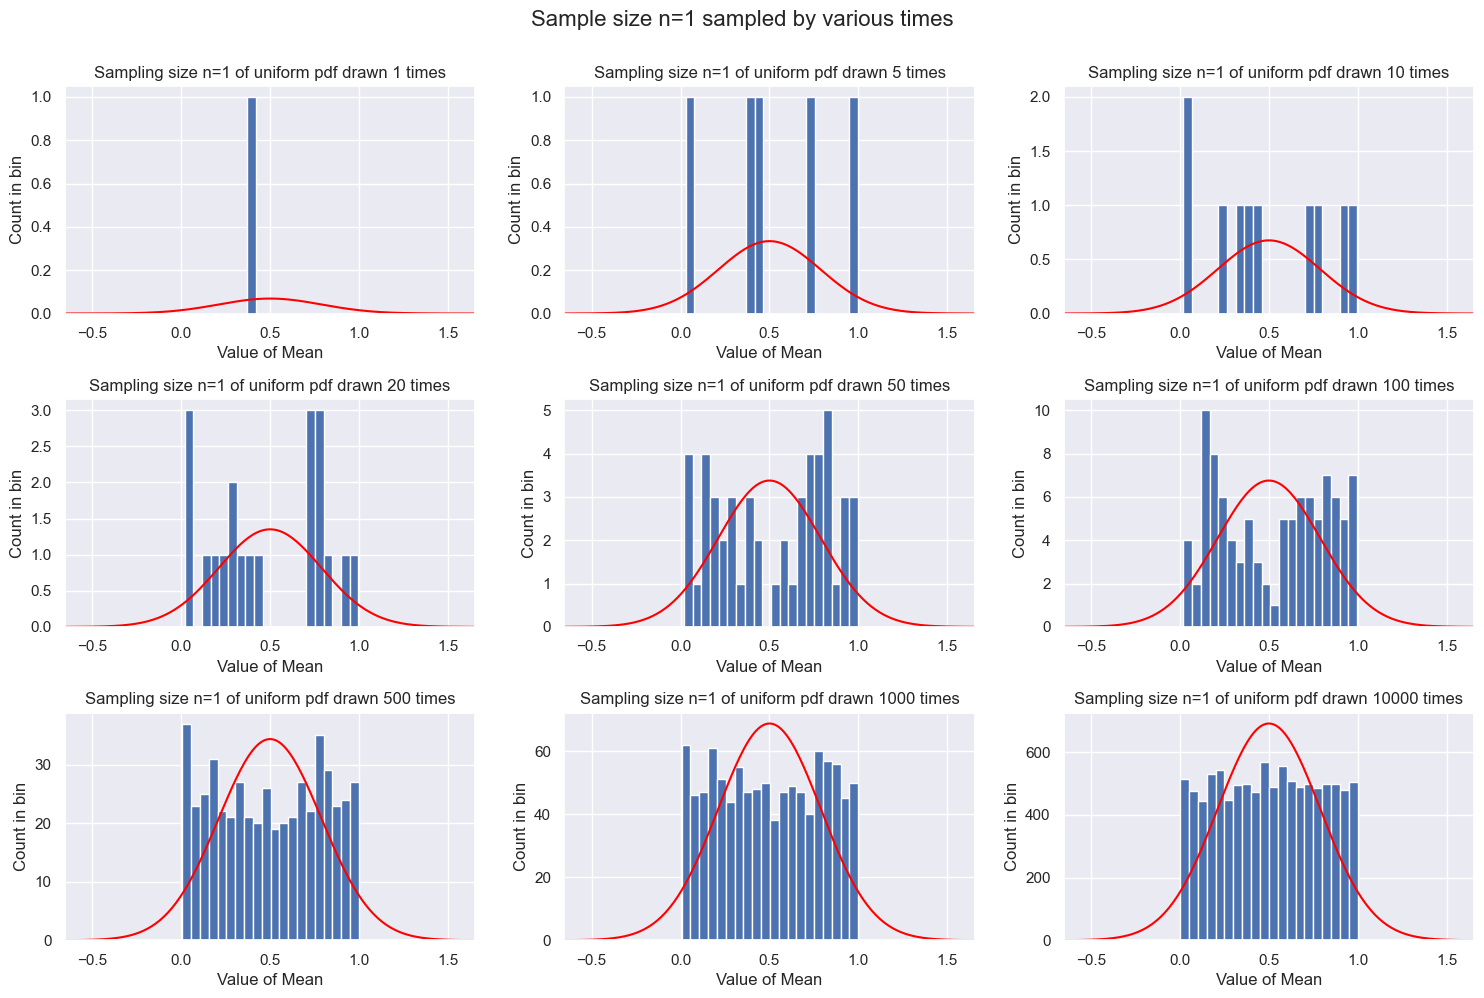

In [11]:
plot_sample_result(1, 20)   # n=1 so just the original distribution

As expected, we just get a better and better reproduction of the original distribution, which is uniform in this case. We don't expect any connection to a Gaussian from the CLT in this case.

### Second example: each sample is two points

So mean is the average of the two points. We divide the means into 20 bins.

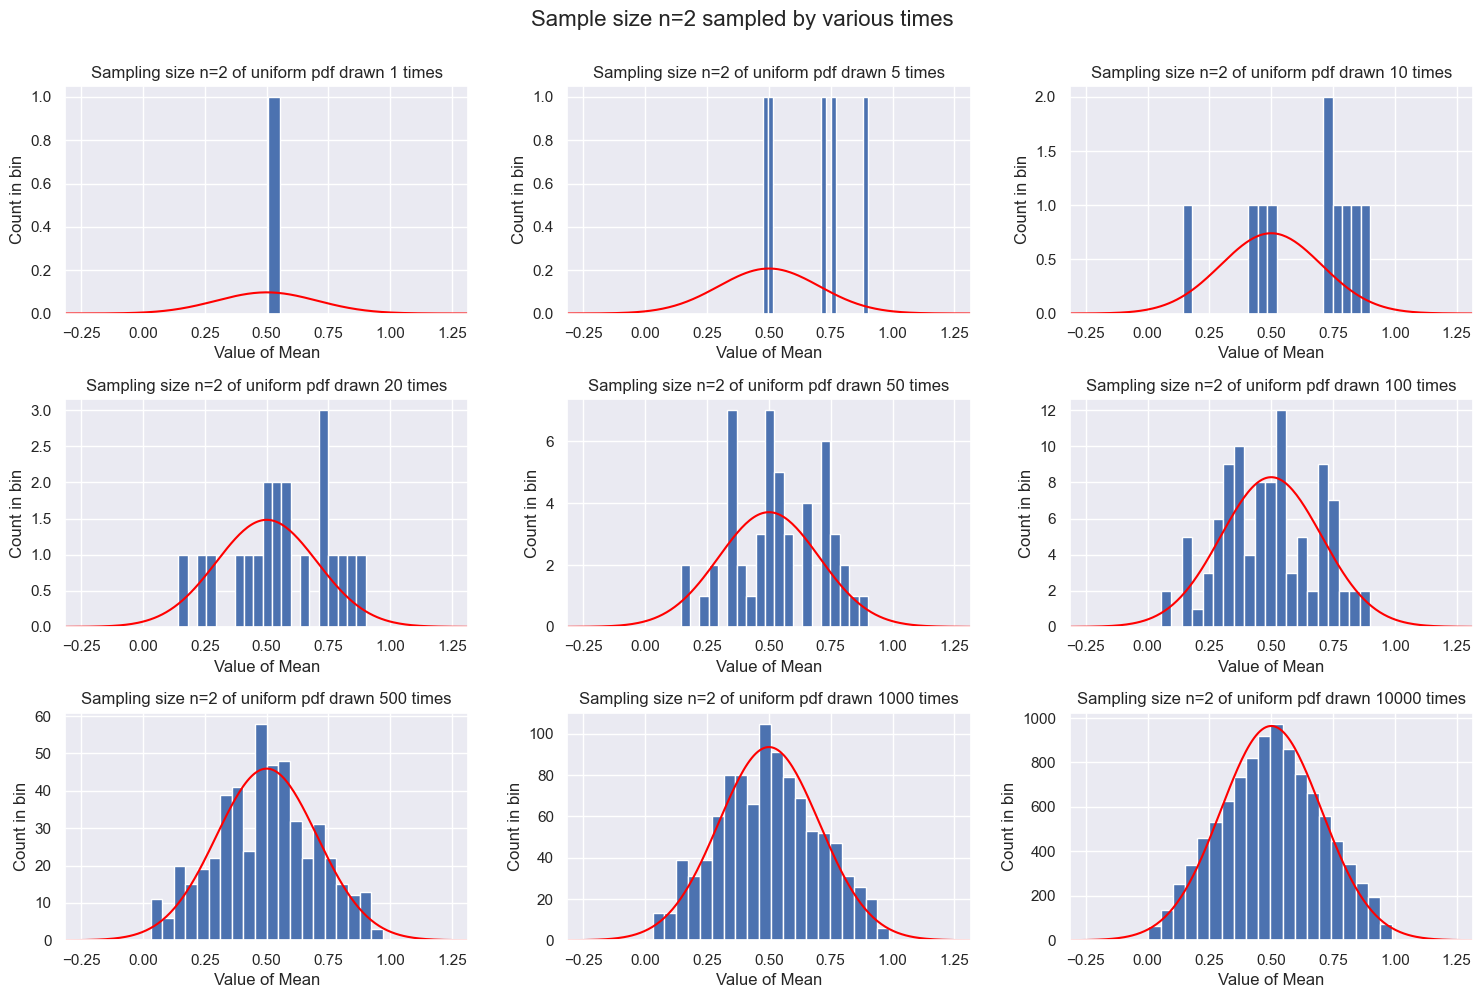

In [12]:
plot_sample_result(2, 20)

As the number of means gets larger, we see that a peak develops at 1/2 and the shape becomes triangular. If we think of the average of two uniformly drawn points from \[0,1\], it is most likely that their average will be close to 1/2 and unlikely to be at the ends (e.g., to get near 0, one would need both numbers to be close to 0).

### Third example: each sample is 10 points

Now we see the trends from $n=2$ being accentuated. By the time we have 10000 means to histogram, it looks like a pretty good Gaussian. Note that the width of the Gaussian is set by the sample size $n=10$, not by how many draws are made. The width decreases as $1/\sqrt{n}$, so from $n=2$ to $n=10$ it is roughly a factor of 2.2 smaller (0.25 vs. 0.1).


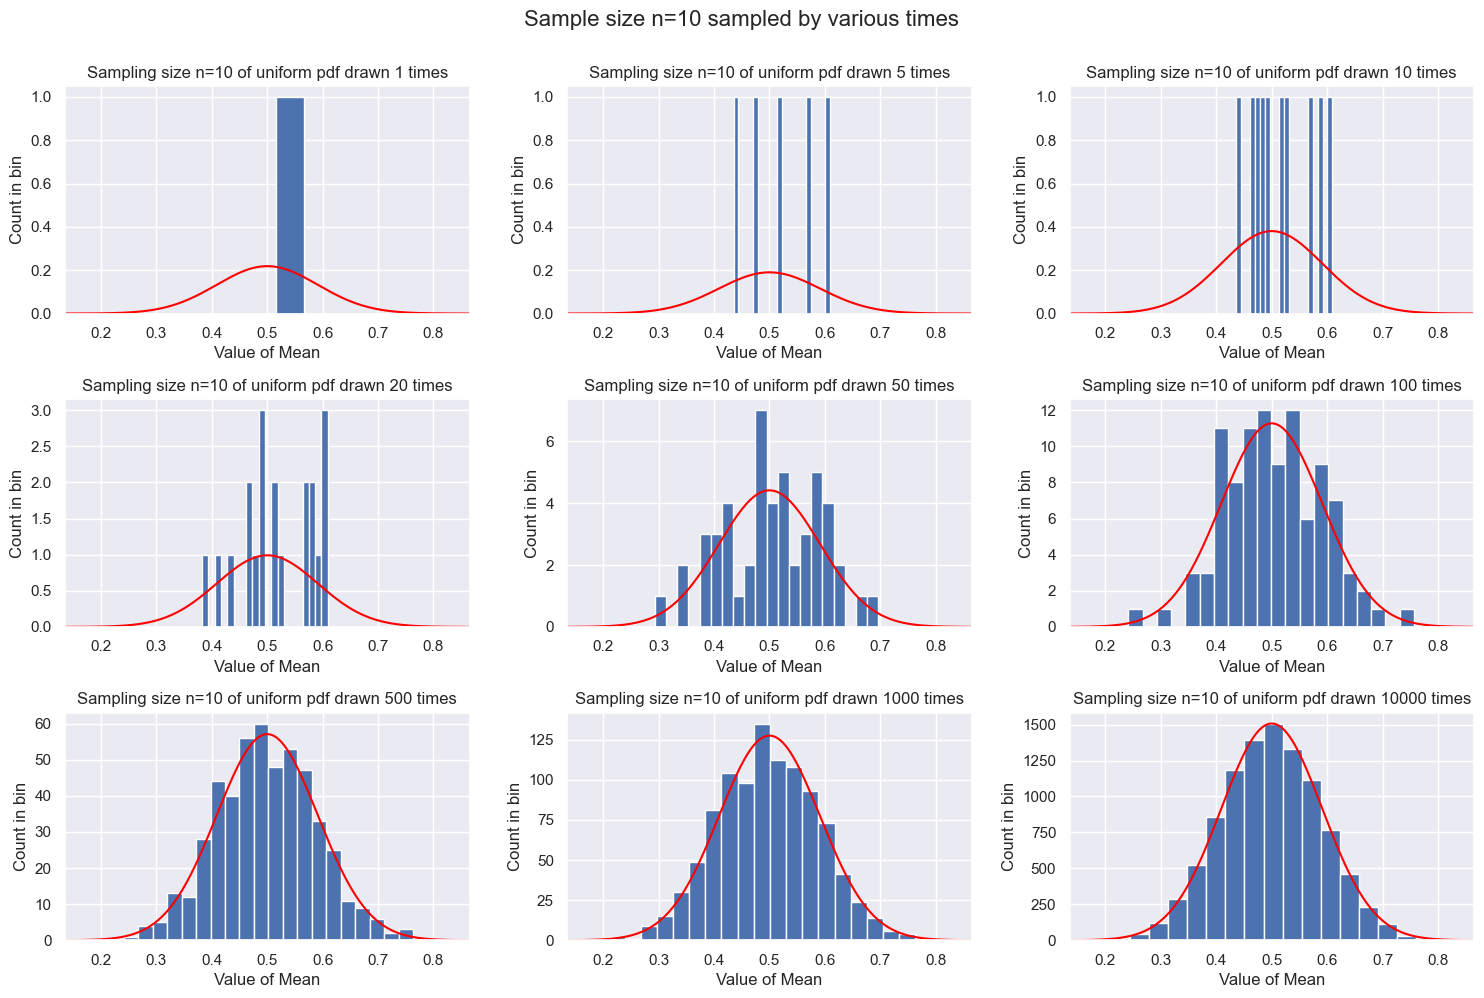

In [13]:
plot_sample_result(10, 20)

### Fourth example: each sample is 50 points

By now we are taking the mean of 50 points with each sample. This will increasingly be close to 1/2 and very rarely far from 1/2. The width decreases as $1/\sqrt{n}$, so from $n=10$ to $n=50$ it is roughly a factor of 2.2 smaller (0.1 vs. 0.04).

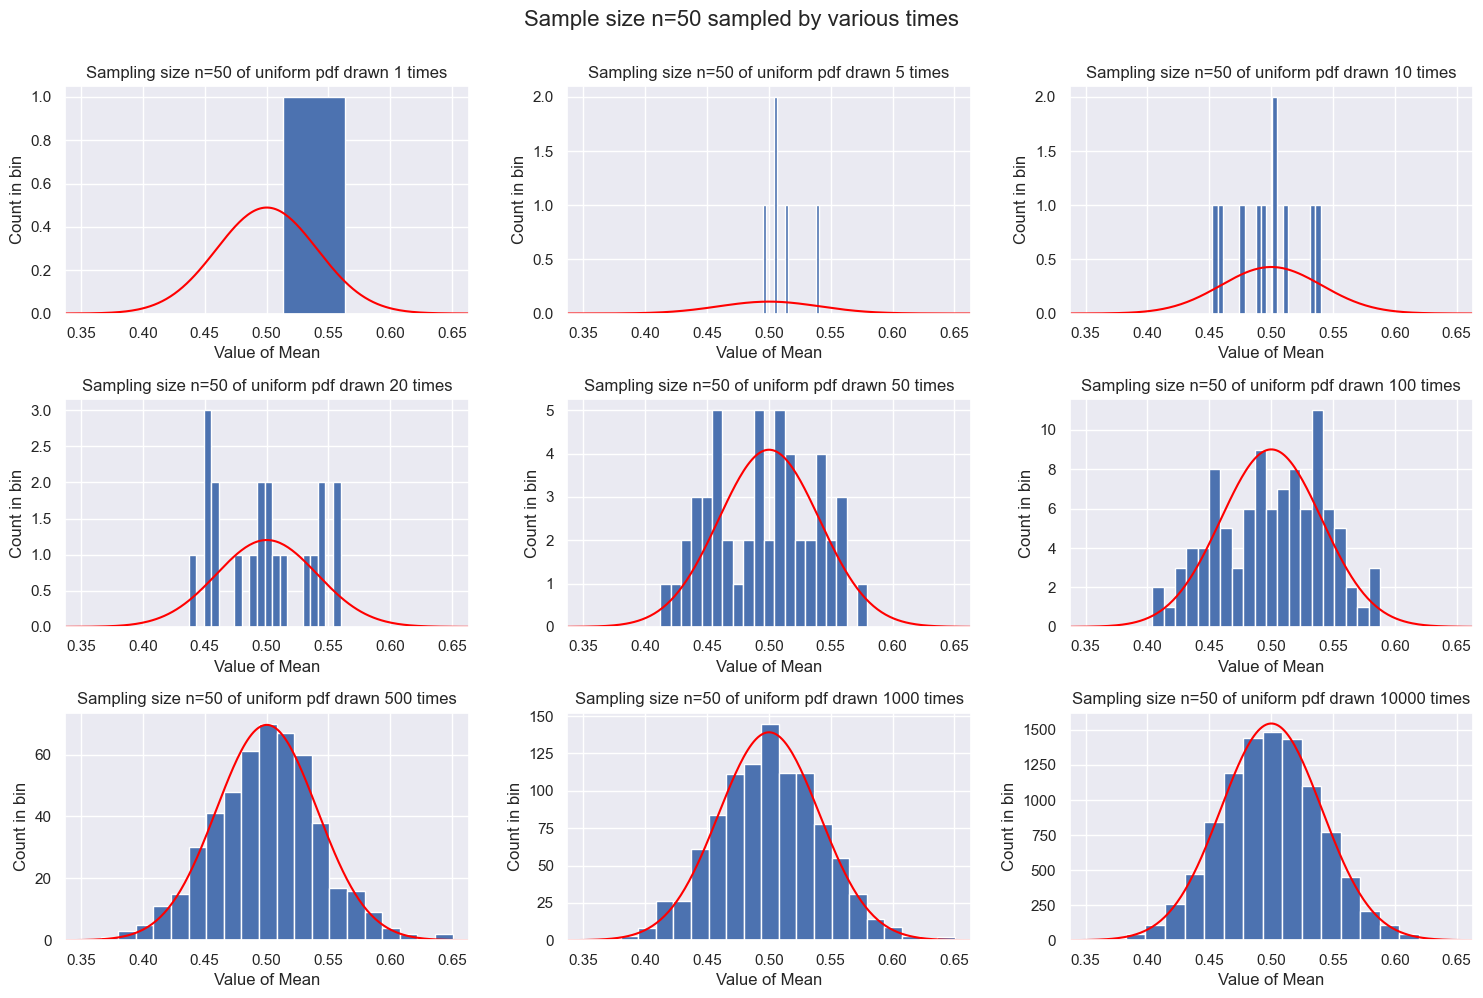

In [14]:
plot_sample_result(50, 20)

## Adding $n$ variables drawn from a distribution

We'll use the results derived for combining $n$ variables drawn from the same zero-mean probability distribution with an overall $1/\sqrt{n}$.  The generalization to different pdfs (and to non-zero means) is straightforward but should be coded more efficiently.

$$
  p(z)  = \int_{-\infty}^{+\infty} \frac{d\omega}{2\pi}\, e^{-i\omega z}
    \left[ \int_{-\infty}^{+\infty}\! dx_1\, e^{i\omega x_1/\sqrt{n}} p(x_1) \right]
    \left[ \int_{-\infty}^{+\infty}\! dx_2\, e^{i\omega x_2/\sqrt{n}} p(x_2) \right]
    \cdots
    \left[ \int_{-\infty}^{+\infty}\! dx_n\, e^{i\omega x_n/\sqrt{n}} p(x_n) \right]
$$

So the idea will be to take a distribution, do an FT with the frequency divided by $\sqrt{n}$, raise it to the $n^{\rm th}$ power, then do an inverse FT.  This should approach a Gaussian as $n$ gets large based on the proof we worked through.

### Doing Fourier transforms by numerical integration (rather than FFT)

We'll try first with the `scipy.integrate` function quad.

In [15]:
from scipy.integrate import quad

def cosineFT(omega, fun):
    """Calculate the cosine Fourier transform (CFT) using quad from
       scipy.integrate with the cosine weight. 
    """
    ans, error = quad(fun, 0., np.inf, weight='cos', wvar=omega)
    return 2.*ans, error   # note the 2 because integration from [0, inf]
    
def cosineFT2(omega, fun):
    """Calculate the cosine Fourier transform (CFT) using quad from
       scipy.integrate with the cosine term added explicitly. 
    """
    integrand = lambda x: np.cos(omega * x) * fun(x)
    ans, error = quad(integrand, -np.inf, np.inf)
    return ans, error

def invCFT(t, omega_pts, FT_pts):
    """Calculate the inverse cosine Fourier transform (invCFT) using numpy's
       trapz function. Includes 1/2\pi factor 
    """
    integrand_pts = np.array( [np.cos(omega * t) * FT_value \
                               for omega, FT_value in zip(omega_pts, FT_pts)] 
                            )
    return np.trapz(integrand_pts, omega_pts) / (2. * np.pi)

def gaussian(x, sigma=1.):
    """One-dimensional normalized Gaussian."""
    return 1./np.sqrt(2. * np.pi * sigma**2) * np.exp(-x**2/(2.*sigma**2))



We'll use a uniform distribution again.

In [16]:
# FT of uniform distribution

x_pts = np.linspace(-4., 4., 401)  # x range

# uniform distribution from -1 to +1
uni_dist = stats.uniform(loc=-1., scale=2.)
uni_dist_pts = uni_dist.pdf(x_pts)

uni_gauss_pts = np.array([gaussian(x, sigma=uni_dist.std()) for x in x_pts])

omega_pts = np.linspace(-40., 40., 401)
#FT_uniform = np.array([cosineFT(omega, uni_dist.pdf)[0] for omega in omega_pts])

def CFT_n(fun, omega_pts, n=1):
    """Take the Fourier transform of fun wrt omega/\sqrt{n} and then
        raise it to the n'th power.
    """
    CFT_n_pts = np.array([cosineFT(omega / np.sqrt(n), fun)[0] \
                          for omega in omega_pts])
    return CFT_n_pts**n

In [17]:
n_vals = np.array([1, 2, 3, 4, 5, 8])
FT_uniform_pts = np.array([CFT_n(uni_dist.pdf, omega_pts, n) \
                           for n in n_vals])

In [18]:
invFT_uniform_pts = np.array([[invCFT(x, omega_pts, FT_uniform_pts[i]) 
                              for x in x_pts] for i in range(n_vals.size)])

The plots below on the right are the $n$ products of the Fourier-transformed distributions
(so this is in the Fourier space) with the frequency divided by $\sqrt{n}$. 
The plots on the left are the inverse Fourier transforms of the plots on the right.

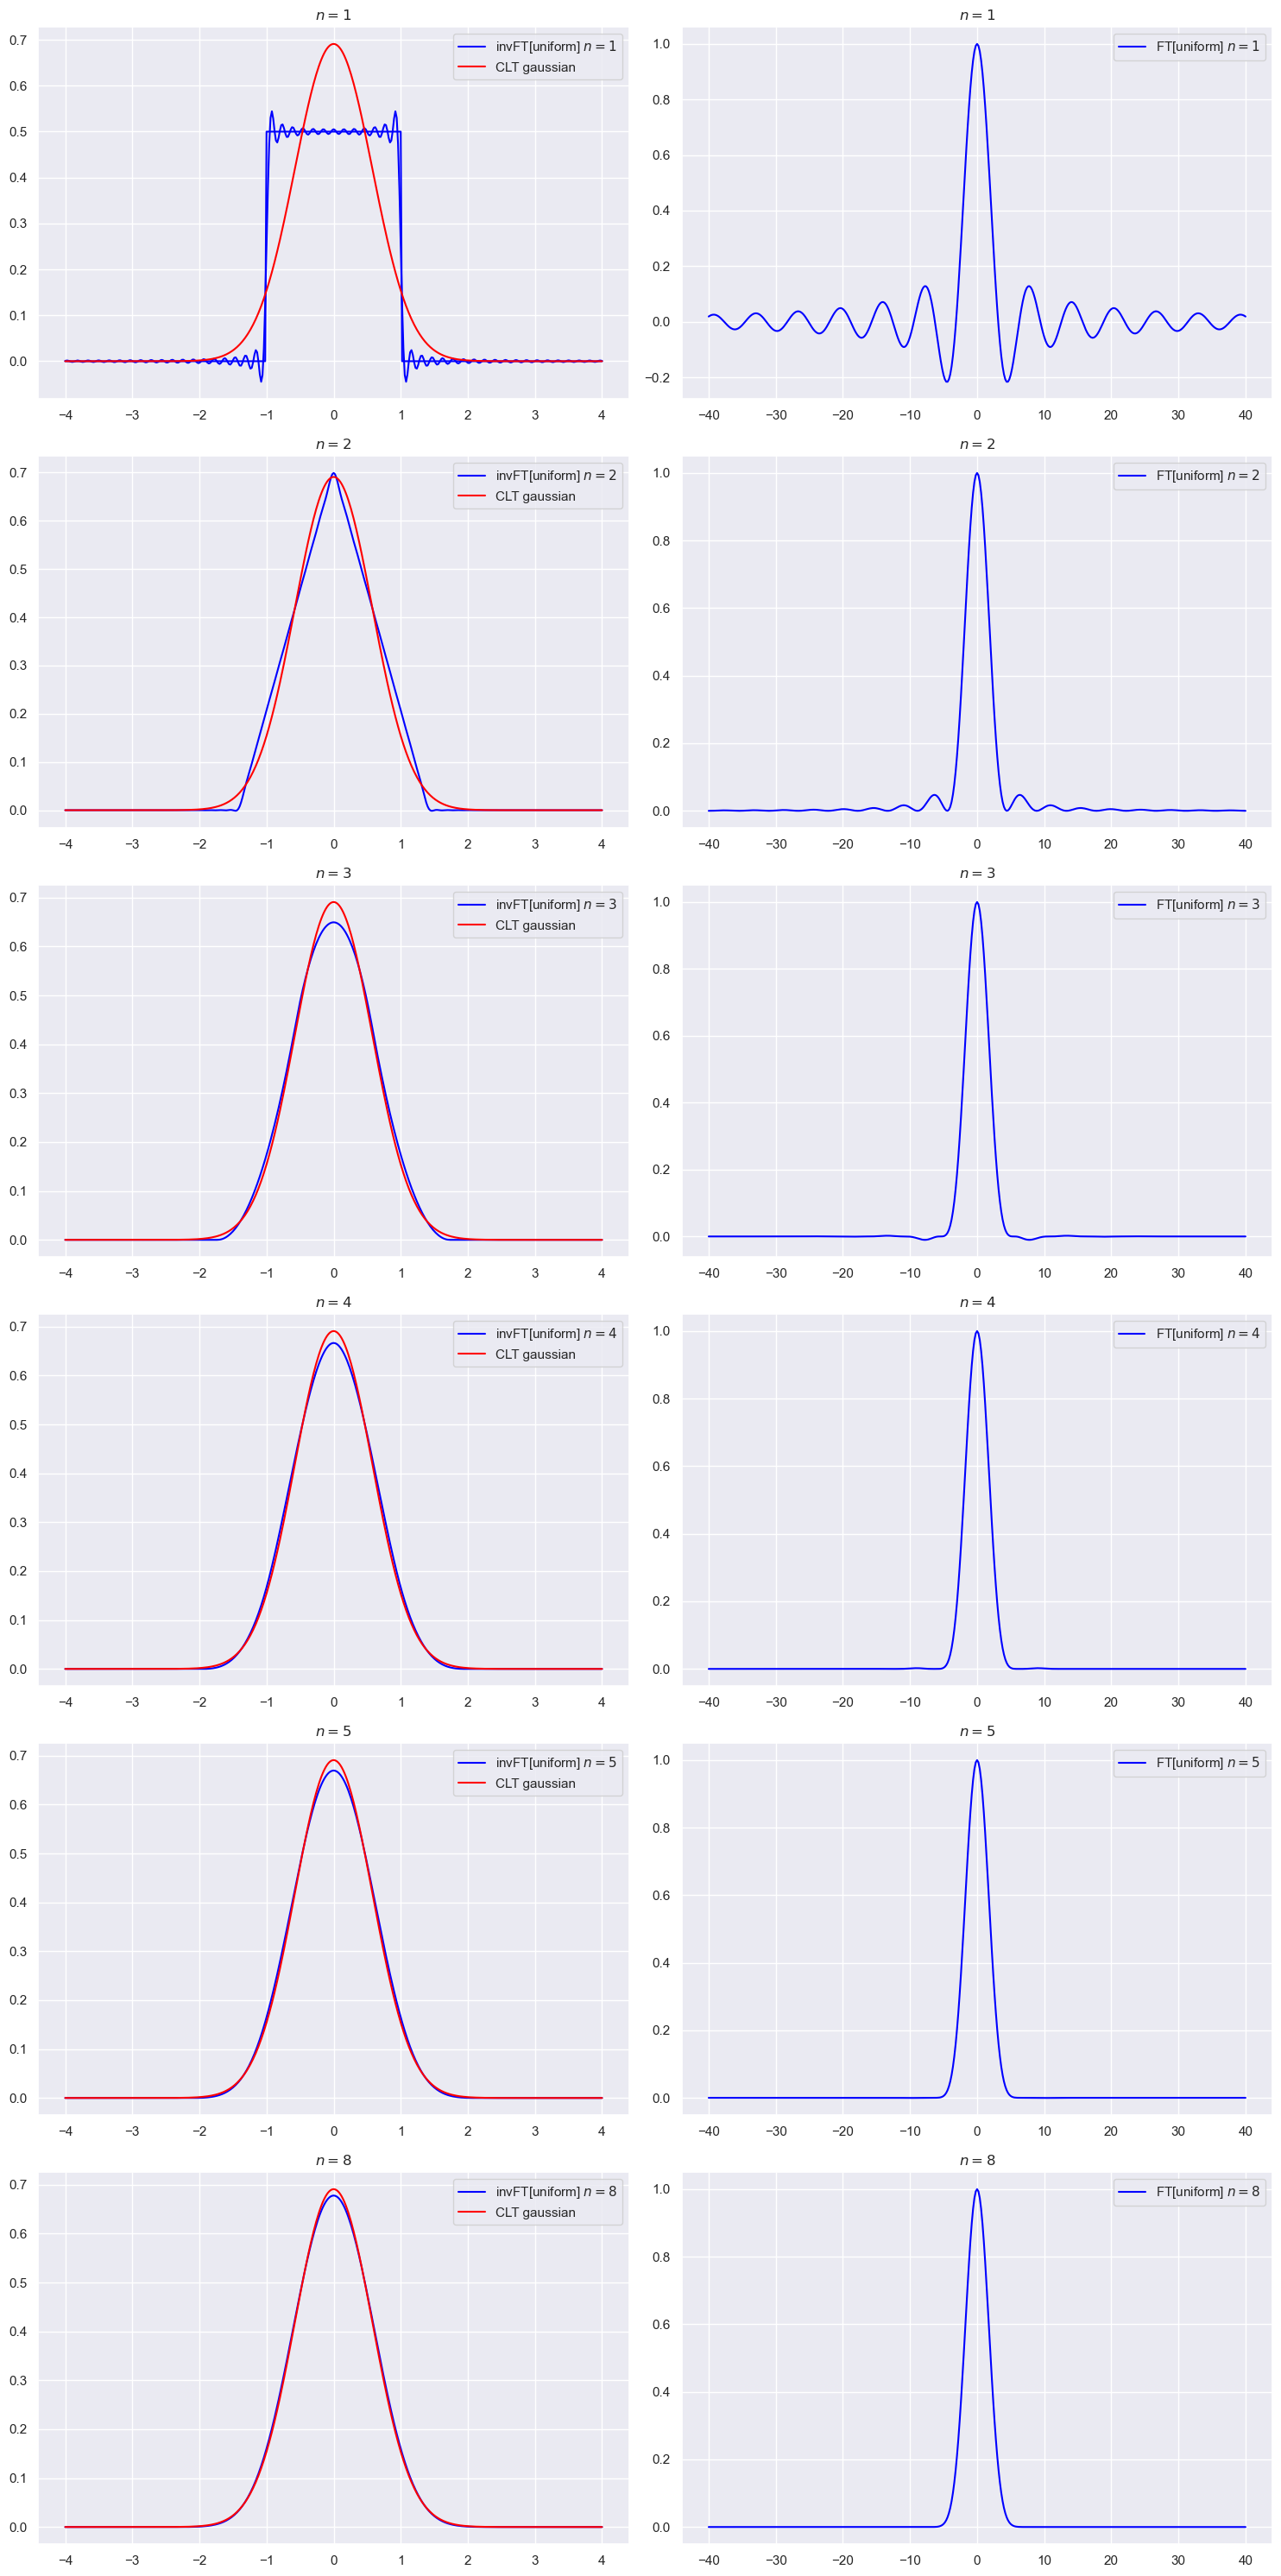

In [19]:
fig, ax = plt.subplots(n_vals.size, 2, figsize=(15, 5 * n_vals.size))
ax[0, 0].plot(x_pts, uni_dist_pts, color='blue')

for index, n in enumerate(n_vals):
    ax[index, 0].plot(x_pts, invFT_uniform_pts[index],
                      color='blue', label=rf'invFT[uniform] $n={n}$')
    ax[index, 0].plot(x_pts, uni_gauss_pts, color='red',
                      label='CLT gaussian')
    ax[index, 0].legend()
    ax[index, 0].set_title(rf'$n = {n}$')
    ax[index, 1].plot(omega_pts, FT_uniform_pts[index],
                      color='blue', label=rf'FT[uniform] $n={n}$')
    ax[index, 1].legend()
    ax[index, 1].set_title(rf'$n = {n}$')
    
fig.tight_layout()

So we see that multiplying the original Fourier transform will rapidly kill off the tails and highlight the central part. The $n$ scalings enforces that the Gaussians in both the original and Fourier space have constant variances.